In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import visualkeras

In [5]:
from sklearn.model_selection import train_test_split

def load_and_preprocess_data():
    """Load and preprocess the CIFAR10 dataset."""
    # Load the CIFAR10 dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    # Normalize pixel values to be between 0 and 1
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    # Split the training set into a training and validation set
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
    
    # Convert the label vectors to one-hot encoded format
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    y_val = tf.keras.utils.to_categorical(y_val, 10)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [3]:
def create_model():
    """Create a simple CNN model."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, x_train, y_train, x_val, y_val):
    """Train the model and add callbacks."""
    history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))
    return history

def visualize_model(model):
    """Visualize the model architecture."""
    visualkeras.layered_view(model).show()

def evaluate_model(model, x_test, y_test):
    """Evaluate the model on the test set."""
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess_data()
model = create_model()
history = train_model(model, x_train, y_train, x_val, y_val)
visualize_model(model)

Epoch 1/50
1407/1407 [==============================] - 11s 7ms/step - loss: 1.6908 - accuracy: 0.4093 - val_loss: 1.4281 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 2/50
1407/1407 [==============================] - 9s 7ms/step - loss: 1.3751 - accuracy: 0.5323 - val_loss: 1.2776 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 3/50
1407/1407 [==============================] - 9s 6ms/step - loss: 1.2548 - accuracy: 0.5825 - val_loss: 1.1854 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 4/50
1407/1407 [==============================] - 8s 5ms/step - loss: 1.1749 - accuracy: 0.6147 - val_loss: 1.1567 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 5/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.1067 - accuracy: 0.6410 - val_loss: 1.0724 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 6/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0569 - accuracy: 0.6613 - val_loss: 1.0665 - val_accuracy: 0.6634 - lr: 0.0010
Epoch 7/50
1407/1407 [==============================] - 7

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Text(0.5, 1.0, 'Loss')

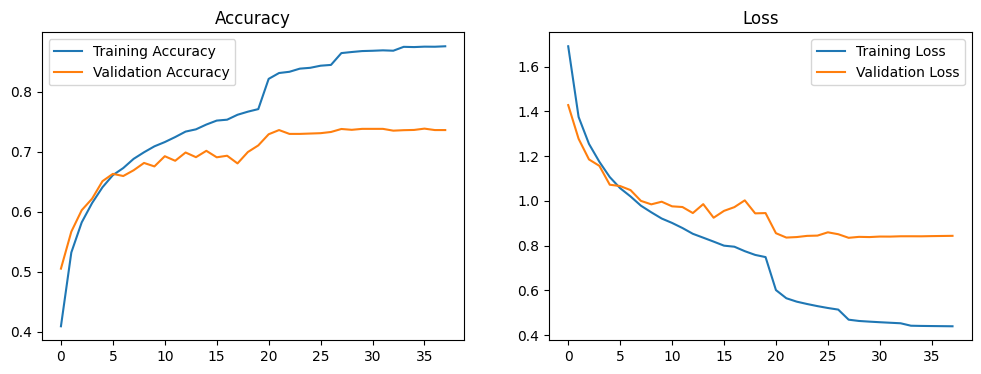

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

In [8]:
evaluate_model(model, x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.8546 - accuracy: 0.7389
Test Loss: 0.8546372056007385, Test Accuracy: 0.7389000058174133
